In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [3]:
import sklearn
import graphviz
import pandas as pd

import dtreeviz

# Set up the dataset

In [4]:
random_state = 1234 # get reproducible trees

dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Set up the pipeline

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [6]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

In [7]:
model = make_pipeline(
    VarianceThreshold(0.5),
    PolynomialFeatures(degree=2, interaction_only=True),
    DecisionTreeClassifier(max_depth=4))

In [8]:
model.fit(dataset[features], dataset[target])

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=0.5)),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4))])

### Extract relevant parameters for `dtreeviz` from the pipeline


As the model used has several preprocessing steps prior the decision tree, its feature space is different from `dataset[features]`. Hence, we first have to extract the relevant parameters from the pipeline before passing them to `dtreeviz`. Here, we use the following helper function from the `dtreeviz.utils` module:

In [9]:
from dtreeviz.utils import extract_params_from_pipeline

In [10]:
tree_classifier, X_train, features_model = extract_params_from_pipeline(
    pipeline=model,
    X_train=dataset[features],
    feature_names=features)

/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [11]:
y_train = dataset[target]

In [12]:
features_model

['1',
 'Pclass',
 'Age',
 'Fare',
 'Cabin_label',
 'Embarked_label',
 'Pclass Age',
 'Pclass Fare',
 'Pclass Cabin_label',
 'Pclass Embarked_label',
 'Age Fare',
 'Age Cabin_label',
 'Age Embarked_label',
 'Fare Cabin_label',
 'Fare Embarked_label',
 'Cabin_label Embarked_label']

## Initialize dtreeviz model (adaptor)


In [13]:
viz_model = dtreeviz.model(tree_classifier,
                           X_train=X_train, y_train=y_train,
                           feature_names=features_model,
                           target_name=target, class_names=["survive", "perish"])

## Tree structure visualizations

To show the decision tree structure using the default visualization, call `view()`:

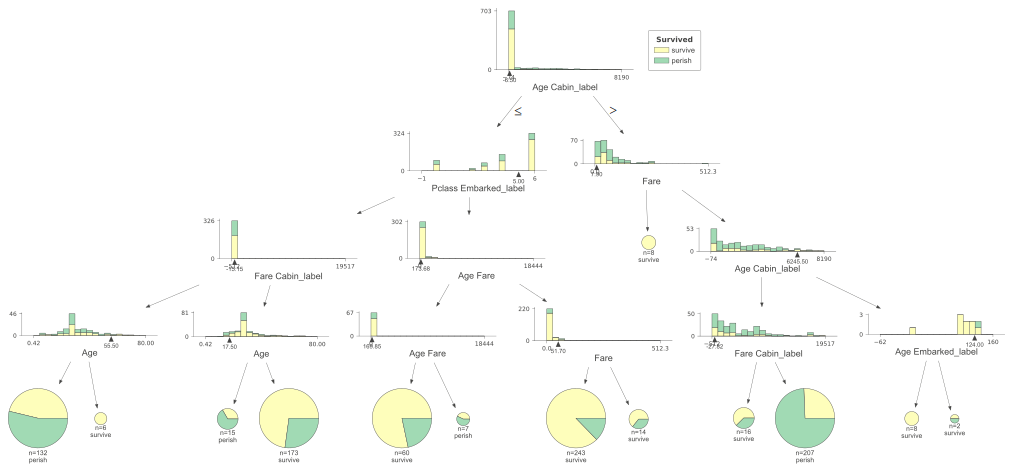

In [14]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

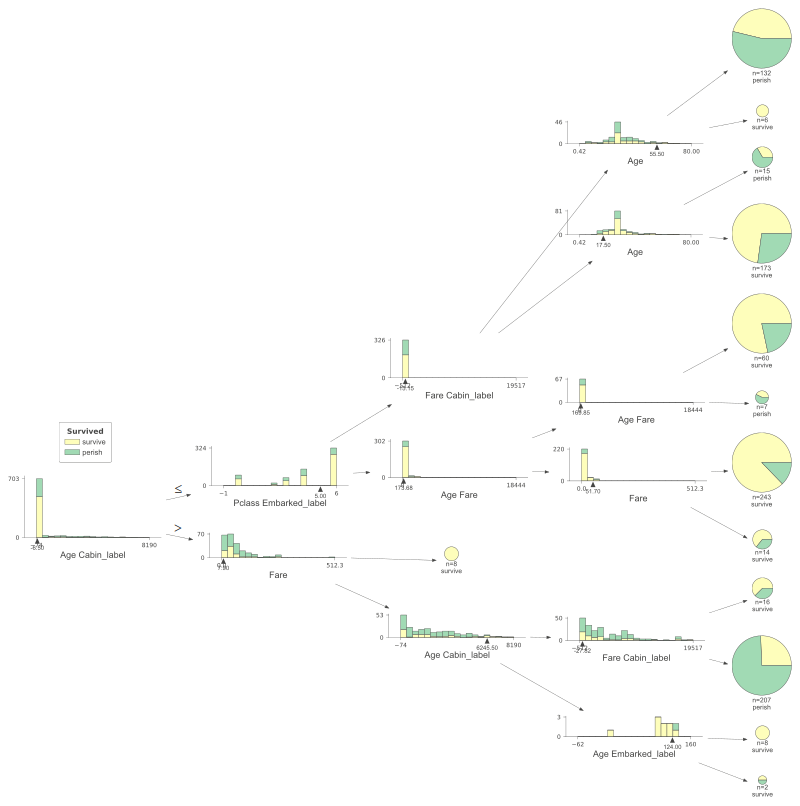

In [15]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

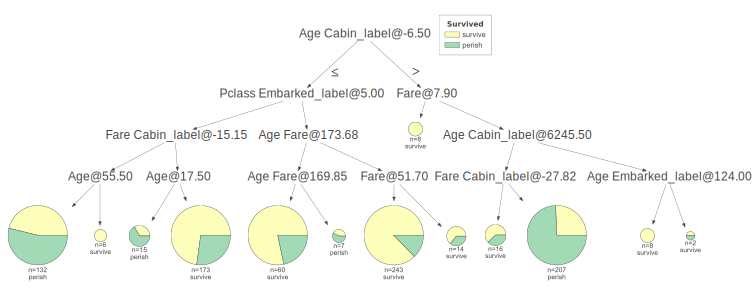

In [16]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

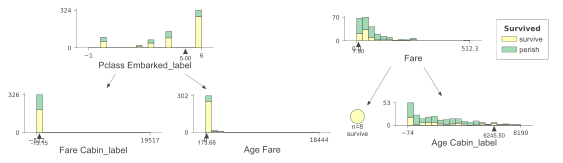

In [17]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [18]:
x = X_train.iloc[10]
x

1                                1.0
Pclass                           3.0
Age                              4.0
Fare                            16.7
Cabin_label                    145.0
Embarked_label                   2.0
Pclass Age                      12.0
Pclass Fare                     50.1
Pclass Cabin_label             435.0
Pclass Embarked_label            6.0
Age Fare                        66.8
Age Cabin_label                580.0
Age Embarked_label               8.0
Fare Cabin_label              2421.5
Fare Embarked_label             33.4
Cabin_label Embarked_label     290.0
Name: 10, dtype: float64

and then display the path through the tree structure:

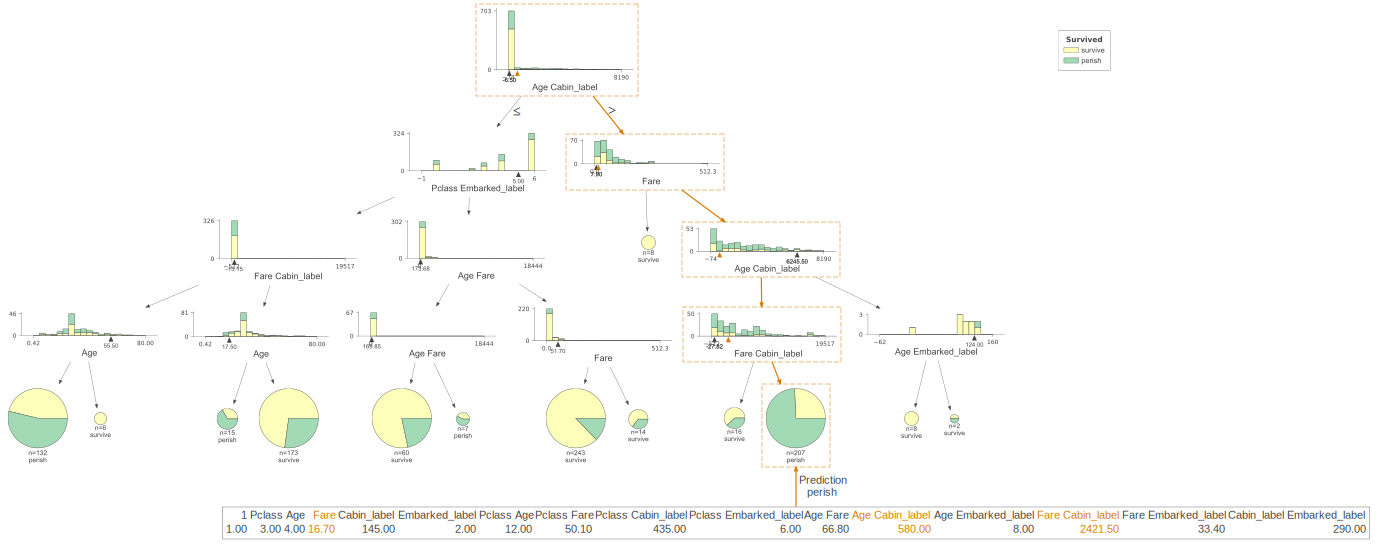

In [19]:
viz_model.view(x=x)

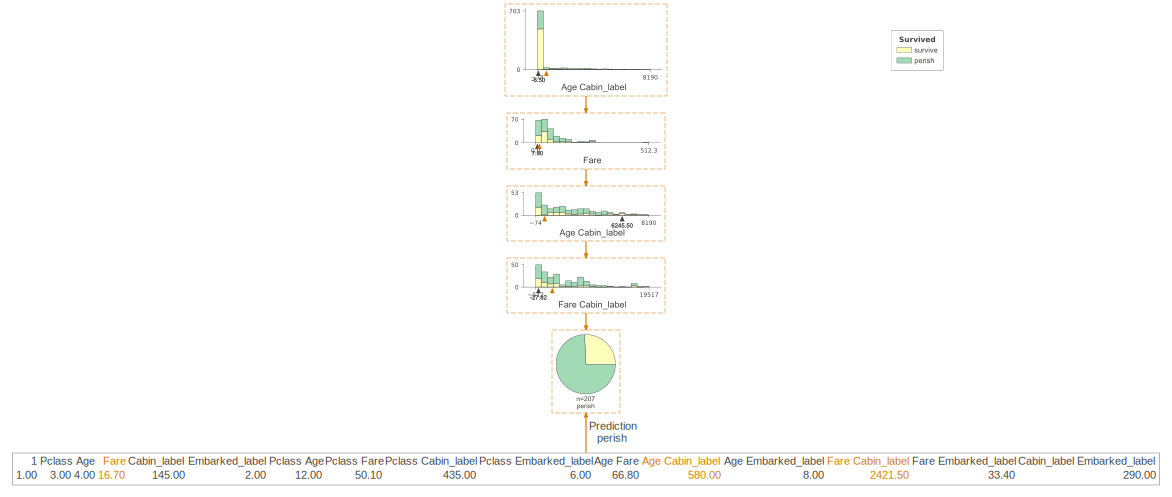

In [20]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [21]:
print(viz_model.explain_prediction_path(x))

7.9 <= Fare 
-6.5 <= Age Cabin_label  < 6245.5
-27.82 <= Fare Cabin_label 



If you'd like the feature importance for a specific instance, as calculated by the underlying decision tree library, use `instance_feature_importance()`:

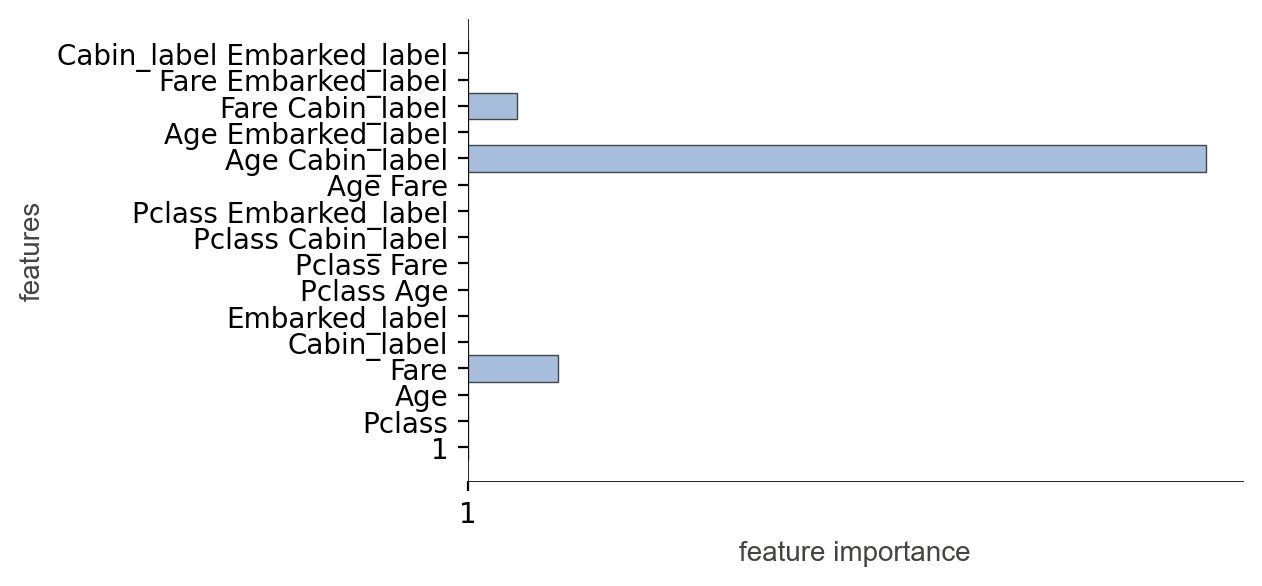

In [22]:
viz_model.instance_feature_importance(x)

## Leaf info

There are a number of functions to get information about the leaves of the tree.

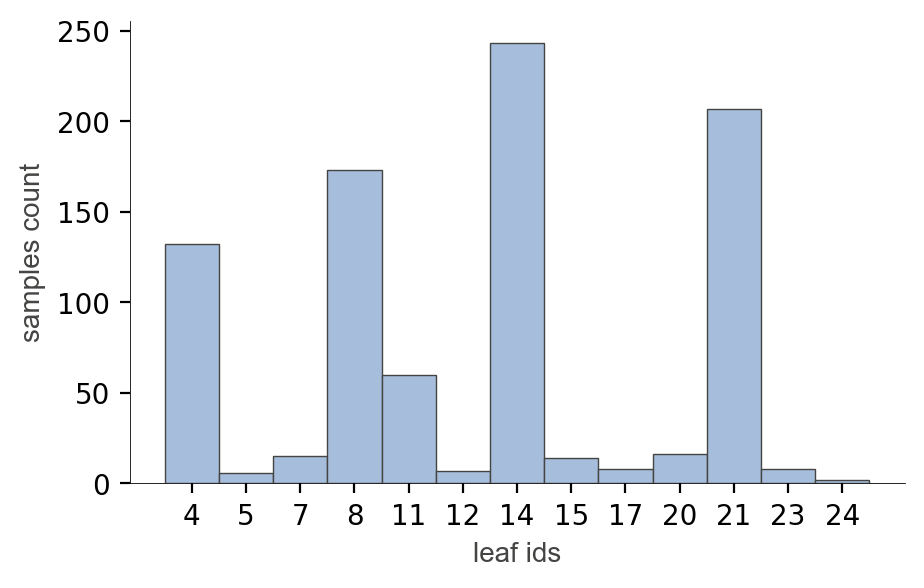

In [23]:
viz_model.leaf_sizes()

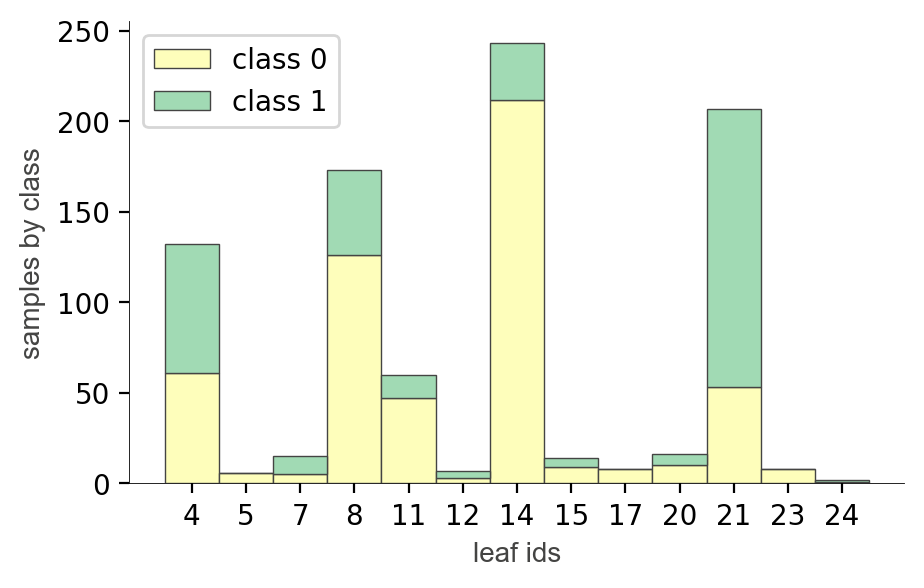

In [24]:
viz_model.ctree_leaf_distributions()

In [25]:
viz_model.node_stats(node_id=14)

,1,Pclass,Age,Fare,Cabin_label,Embarked_label,Pclass Age,Pclass Fare,Pclass Cabin_label,Pclass Embarked_label,Age Fare,Age Cabin_label,Age Embarked_label,Fare Cabin_label,Fare Embarked_label,Cabin_label Embarked_label
count,243.0,243.0,243.000000,243.000000,243.0,243.0,243.000000,243.000000,243.0,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.0
mean,1.0,3.0,30.080466,13.064468,-1.0,2.0,90.241398,39.193405,-3.0,6.0,365.770829,-30.080466,60.160932,-13.064468,26.128937,-2.0
std,0.0,0.0,9.713770,9.057148,0.0,0.0,29.141311,27.171443,0.0,0.0,256.760779,9.713770,19.427541,9.057148,18.114295,0.0
min,1.0,3.0,7.000000,6.237500,-1.0,2.0,21.000000,18.712500,-3.0,6.0,173.707600,-74.000000,14.000000,-46.900000,12.475000,-2.0
25%,1.0,3.0,25.000000,7.895800,-1.0,2.0,75.000000,23.687400,-3.0,6.0,223.064169,-33.500000,50.000000,-15.975000,15.791600,-2.0
50%,1.0,3.0,29.699118,8.050000,-1.0,2.0,89.097353,24.150000,-3.0,6.0,266.000000,-29.699118,59.398235,-8.050000,16.100000,-2.0
75%,1.0,3.0,33.500000,15.975000,-1.0,2.0,100.500000,47.925000,-3.0,6.0,414.575000,-25.000000,67.000000,-7.895800,31.950000,-2.0
max,1.0,3.0,74.000000,46.900000,-1.0,2.0,222.000000,140.700000,-3.0,6.0,2016.700000,-7.000000,148.000000,-6.237500,93.800000,-2.0


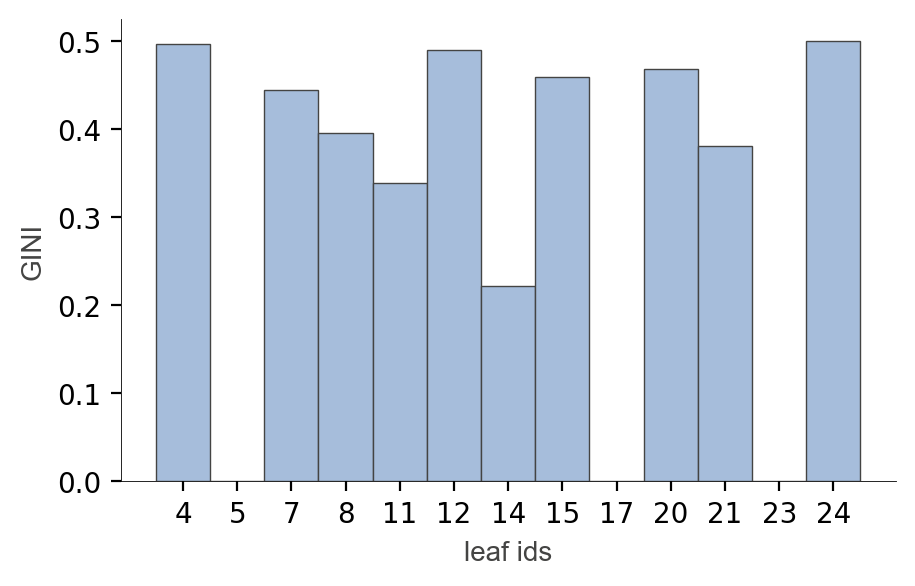

In [26]:
viz_model.leaf_purity()